<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="在 Colab 中打开"/></a>

# 使用Google的Gemini模型进行图像理解和构建带有LlamaIndex的检索增强生成的多模态LLM

在这个笔记本中，我们将展示如何使用Google的Gemini Vision模型进行图像理解。

首先，我们展示了我们目前支持的Gemini的几个函数：
* `complete`（同步和异步都支持）：针对单个提示和图像列表
* `chat`（同步和异步都支持）：针对多个聊天消息
* `stream complete`（同步和异步都支持）：用于完整输出的流式处理
* `stream chat`（同步和异步都支持）：用于聊天输出的流式处理

在本笔记本的第二部分，我们尝试使用`Gemini` + `Pydantic`来解析来自Google地图的图像的结构化信息。
* 定义所需的带有属性字段的Pydantic类
* 让`gemini-pro-vision`模型理解每个图像并输出结构化结果

在本笔记本的第三部分，我们建议使用Gemini和LlamaIndex来构建一个简单的`检索增强生成`流程，用于一个小型的Google地图餐厅数据集。
* 基于第2步的结构化输出构建向量索引
* 使用`gemini-pro`模型合成结果，并根据用户查询推荐餐厅。

注意：`google-generativeai`仅适用于特定的国家和地区。


In [ ]:
%pip install llama-index-multi-modal-llms-gemini
%pip install llama-index-vector-stores-qdrant
%pip install llama-index-embeddings-gemini
%pip install llama-index-llms-gemini

In [ ]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

在这个示例中，我们将使用Gemini库来从URL加载图像，并对其进行分析。Gemini是一个用于图像分析和处理的Python库，它提供了许多有用的功能，包括图像加载、预处理、特征提取等。

首先，我们需要安装Gemini库，如果你还没有安装的话。你可以使用以下命令来安装Gemini：

```bash
pip install gemini
```

安装完成后，我们可以开始加载图像并进行分析。


In [ ]:
%env GOOGLE_API_KEY=...

In [ ]:

import os

GOOGLE_API_KEY = ""  # 在这里添加你的GOOGLE API密钥
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## 初始化`GeminiMultiModal`并从URL加载图像


In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://storage.googleapis.com/generativeai-downloads/data/scene.jpg",
    # 在这里添加你自己的图片链接！
]

image_documents = load_image_urls(image_urls)

gemini_pro = GeminiMultiModal(model_name="models/gemini-pro-vision")

https://storage.googleapis.com/generativeai-downloads/data/scene.jpg


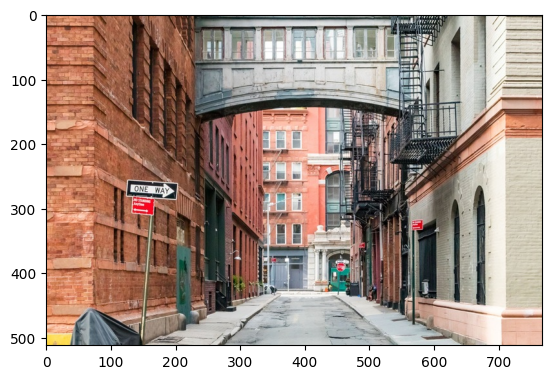

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

img_response = requests.get(image_urls[0])
print(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

### 使用一组图片完成一个提示任务


In [ ]:
complete_response = gemini_pro.complete(
    prompt="Identify the city where this photo was taken.",
    image_documents=image_documents,
)

In [ ]:
print(complete_response)

 New York City


### Steam 完成一个包含大量图片的提示


In [ ]:
stream_complete_response = gemini_pro.stream_complete(
    prompt="Give me more context for this image",
    image_documents=image_documents,
)

In [ ]:
for r in stream_complete_response:
    print(r.text, end="")

 This is an alleyway in New York City. It is between two tall buildings and there is a bridge going over the alleyway. The buildings are made of red brick and there are fire escapes on the buildings. The alleyway is empty except for a few trash cans.

### 异步完成


In [ ]:
response_acomplete = await gemini_pro.acomplete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

In [ ]:
print(response_acomplete)

### 异步流完整


In [ ]:
response_astream_complete = await gemini_pro.astream_complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

In [ ]:
async for delta in response_astream_complete:
    print(delta.text, end="")

## 包含两张图片的完成版


In [ ]:
image_urls = [
    "https://www.sportsnet.ca/wp-content/uploads/2023/11/CP1688996471-1040x572.jpg",
    "https://res.cloudinary.com/hello-tickets/image/upload/c_limit,f_auto,q_auto,w_1920/v1640835927/o3pfl41q7m5bj8jardk0.jpg",
    # "https://www.cleverfiles.com/howto/wp-content/uploads/2018/03/minion.jpg",
]

image_documents_1 = load_image_urls(image_urls)

response_multi = gemini_pro.complete(
    prompt="这些图片之间是否存在任何关系？",
    image_documents=image_documents_1,
)
print(response_multi)

## 第二部分：使用`Gemini` + `Pydantic`对图像进行结构化输出解析

* 利用Gemini进行图像推理
* 使用Pydantic程序从Gemini的图像推理结果中生成结构化输出


In [ ]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

列出`google.generativeai`中可用的Gemini模型。
确保您的API密钥可以访问以下模型


In [ ]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


### 下载示例图片以了解Gemini

在这个示例中，我们将下载一些示例图片，以便了解Gemini的功能和用法。


In [ ]:
from pathlib import Path

input_image_path = Path("google_restaurants")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg" -O ./google_restaurants/miami.png
!wget "https://docs.google.com/uc?export=download&id=1dYZy17bD6pSsEyACXx9fRMNx93ok-kTJ" -O ./google_restaurants/orlando.png
!wget "https://docs.google.com/uc?export=download&id=1ShPnYVc1iL_TA1t7ErCFEAHT74-qvMrn" -O ./google_restaurants/sf.png
!wget "https://docs.google.com/uc?export=download&id=1WjISWnatHjwL4z5VD_9o09ORWhRJuYqm" -O ./google_restaurants/toronto.png

### 定义用于结构化解析器的Pydantic类


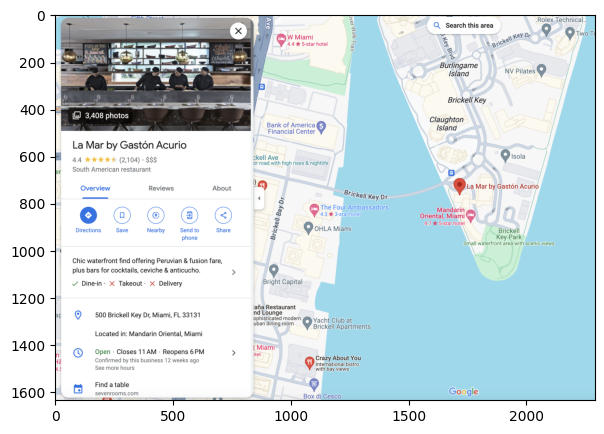

In [ ]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class GoogleRestaurant(BaseModel):
    """谷歌餐厅的数据模型。"""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "./google_restaurants/miami.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### 调用Pydantic程序并生成结构化输出


In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
    你能总结一下图片中的内容，并以json格式返回答案\
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### 通过Gemini Vision模型生成Pydantic结构化输出

在这个示例中，我们将演示如何使用Gemini Vision模型生成Pydantic结构化输出。Gemini Vision是一个用于计算机视觉任务的开源模型，可以用于图像分类、对象检测等任务。我们将展示如何将Gemini Vision模型的输出转换为Pydantic模型，以便于在Python中进行进一步的处理和分析。


In [ ]:
from llama_index.core import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./google_restaurants"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # 仅输出迈阿密的结果示例以及图像
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

('restaurant', 'La Mar by Gaston Acurio')
('food', 'South American')
('location', '500 Brickell Key Dr, Miami, FL 33131')
('category', 'Restaurant')
('hours', 'Open ⋅ Closes 11 PM')
('price', 3.0)
('rating', 4)
('review', '4.4 (2,104)')
('description', 'Chic waterfront find offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticucho.')
('nearby_tourist_places', 'Brickell Key Park')


`观察`：
* Gemini完美地生成了我们需要用于Pydantic类的所有元信息
* 它还可以从`Google Maps`识别附近的公园


## 第三部分：构建多模态RAG进行餐厅推荐

我们的堆栈包括Gemini + LlamaIndex + Pydantic结构化输出功能


### 构建文本节点以构建向量存储。存储每家餐厅的元数据和描述。


In [ ]:
# from llama_index.core.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # 将描述设置为TextNode的文本
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### 使用Gemini嵌入构建密集检索的向量存储。将餐厅作为节点索引到向量存储中


In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import Settings
from llama_index.core import StorageContext
import qdrant_client


# 创建一个本地的Qdrant向量存储
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# 使用嵌入模型到Gemini
Settings.embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
Settings.llm = Gemini(api_key=GOOGLE_API_KEY)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

### 使用Gemini来综合结果并向用户推荐餐馆


In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Orlando restaurant for me and its nearby tourist places"
)
print(response)

For a delightful dining experience, I recommend Mythos Restaurant, known for its American cuisine and unique underwater theme. Overlooking Universal Studios' Inland Sea, this restaurant offers a captivating ambiance. After your meal, explore the nearby tourist attractions such as Universal's Islands of Adventure, Skull Island: Reign of Kong, The Wizarding World of Harry Potter, Jurassic Park River Adventure, and Hollywood Rip Ride Rockit, all located near Mythos Restaurant.
